In [32]:
### IMPORTS ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from dictionaries import *
from ANN import *


In [33]:
### GLOBAL PARAMETERS ###

t = time.time()         # to display runtime later
sample_size = 4
filename = 'ML_input_' + str(sample_size) + 'gm.csv'


In [34]:
### DATA IMPORT ###

# split parameters
test_size = 0.2
random_state = 42

# read in
attr_data = pd.read_csv(filename, usecols = attr_keys).values
labl_data = pd.read_csv(filename, usecols = labl_keys).values

# test/train split
attr_train, attr_test, labl_train, labl_test = train_test_split(attr_data, labl_data, test_size=test_size, random_state=random_state)


In [35]:
## MODEL PARAMETERS ###

# CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Layers
n_in = len(attr_keys)
n_out = len(labl_keys)
n_hidden = 60

# Training
learning_rate = 0.001
epochs = 5000

# Optimiser
optimiser = torch.optim.Adamax

# Activation
activation_fn = nn.Sigmoid()

# Loss
loss_fn = nn.L1Loss()

# plot interval
rec_interval = 5


In [36]:
### LOGISTICAL REGRESSION MODEL ###

# Run a logistic regression before doing the tensor conversion
logit = LogisticRegression(solver='liblinear')
lr_accs = [0.]*n_out

for i in [1,3]:
    logit.fit(attr_train, labl_train.T[i])
    lr_accs[i] = logit.predict_proba(attr_test)[:,1].tolist()
for i in [0,2]:
    lr_accs[i] = [0.]*len(lr_accs[1]) # continuous outputs cannot be modelled, placeholder values used


In [37]:
### TENSOR CONVERSIONS ###

lr_accs = torch.FloatTensor(lr_accs).T
attr_train = torch.FloatTensor(attr_train).to(device)
attr_test = torch.FloatTensor(attr_test).to(device)
labl_train = torch.FloatTensor(labl_train).to(device)
labl_test = torch.FloatTensor(labl_test).to(device)

In [7]:
### INITIALISE AND RUN THE NEURAL NET ###

# Function for reading accuracy of result which rounds to 0 or 1
def binary_acc(Y_hat, labl_test, index):
        
    successes = 0
    confidence = [0]*len(Y_hat)
    calc = Y_hat.T.tolist()[index]
    real = labl_test.T.tolist()[index]

    for i in range(len(calc)):

        confidence[i] = 1 - abs(round(calc[i]) - calc[i])
        successes += int(round(calc[i]) == real[i])
        
    accuracy = successes / len(calc)
    avg_conf = np.mean(confidence)

    return accuracy, avg_conf

def train(optimiser, loss_fn, attr_train, attr_test, labl_train, labl_test, rec_interval, n_in, n_hidden, n_out):

    # initialise model and results storage
    model = ANN(activation_fn, n_in, n_hidden, n_out).to(device)
    optimiser = optimiser(model.parameters(), lr=learning_rate)
    losses = []
    match_win_acc = []
    set_win_acc = []

    # run the model
    for i in range(epochs):

        # calculate
        labl_hat = model.forward(attr_train)
        loss = loss_fn(labl_hat, labl_train)

        # update model
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        # for plotting
        if not i % rec_interval: 
            with torch.no_grad():
                Y_hat = model.forward(attr_test)
            match_win_acc.append(binary_acc(Y_hat, labl_test, 1)[0])
            set_win_acc.append(binary_acc(Y_hat, labl_test, 3)[0])
            losses.append(loss.item())
            
    return model, match_win_acc, set_win_acc, losses

model, match_win_acc, set_win_acc, losses = train(optimiser, loss_fn, attr_train, attr_test, labl_train, labl_test, rec_interval, n_in, n_hidden, n_out)
torch.save(model, 'model_'+str(sample_size)+'gm.torch')

Final Loss: 0.16984952986240387
Runtime: 43.26436901092529s


Text(0.5, 1.0, 'Training Loss')

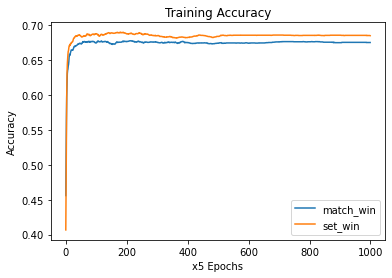

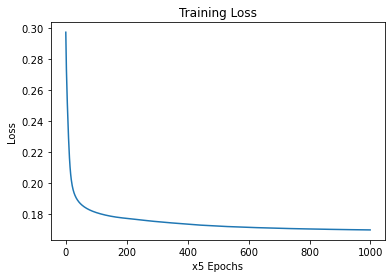

In [8]:
### PLOT AND DISPLAY THE MODEL TRAINING LOSS AND ACCURACY ###

# Display
print(f'Final Loss: {losses[-1]}')
print(f'Runtime: {time.time() - t}s')

# Accuracy
plt.plot(match_win_acc)
plt.plot(set_win_acc)
plt.ylabel('Accuracy')
plt.xlabel(f'x{rec_interval} Epochs')
plt.title('Training Accuracy')
plt.legend(['match_win', 'set_win'])

# Loss
plt.figure()
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel(f'x{rec_interval} Epochs')
plt.title('Training Loss')


In [9]:
### MEASURE ACCURACY ###

# of the logistic regressions
lr_match_win_acc, lr_match_avg_conf = binary_acc(lr_accs, labl_test, 1)
lr_set_win_acc, lr_set_avg_conf = binary_acc(lr_accs, labl_test, 3)

# Run the model forward with test data
with torch.no_grad():
    Y_hat = model.forward(attr_test)

# of the ANN
nn_match_win_acc, nn_match_avg_conf = binary_acc(Y_hat, labl_test, 1)
nn_set_win_acc, nn_set_avg_conf = binary_acc(Y_hat, labl_test, 3)

print(f'nn_match_win correct {round(nn_match_win_acc*100,2)}% of the time with average system confidence {nn_match_avg_conf} for sample size of {sample_size} games')
print(f'lr_match_win correct {round(lr_match_win_acc*100,2)}% of the time with average system confidence {lr_match_avg_conf} for sample size of {sample_size} games')
print(f'nn_set_win correct {round(nn_set_win_acc*100,2)}% of the time  with average system confidence {nn_set_avg_conf} for sample size of {sample_size} games')
print(f'lr_set_win correct {round(lr_set_win_acc*100,2)}% of the time  with average system confidence {lr_set_avg_conf} for sample size of {sample_size} games')
      

nn_match_win correct 67.51% of the time with average system confidence 0.9971408506063304 for sample size of 4 games
lr_match_win correct 68.15% of the time with average system confidence 0.6756597947080083 for sample size of 4 games
nn_set_win correct 68.49% of the time  with average system confidence 0.9978289602343745 for sample size of 4 games
lr_set_win correct 69.0% of the time  with average system confidence 0.6874760692414574 for sample size of 4 games


In [10]:
### MEASURE IMPACT OF EACH INPUT PARAMETER ###

impacts = {k:0 for k in attr_keys}
standard = nn_match_win_acc
on = False

for k in attr_keys:
    
    if not on:
        break
    
    tmp = attr_keys.copy()
    tmp.remove(k)

    # read in
    attr_data = pd.read_csv(filename, usecols = tmp).values
    labl_data = pd.read_csv(filename, usecols = labl_keys).values

    # test/train split
    attr_train, attr_test, labl_train, labl_test = train_test_split(attr_data, labl_data, test_size=test_size, random_state=random_state)

    attr_train = torch.FloatTensor(attr_train).to(device)
    attr_test = torch.FloatTensor(attr_test).to(device)
    labl_train = torch.FloatTensor(labl_train).to(device)
    labl_test = torch.FloatTensor(labl_test).to(device)
    
    model, match_win_acc, set_win_acc, losses = train(optimiser, loss_fn, attr_train, attr_test, labl_train, labl_test, rec_interval, len(tmp), n_hidden, n_out)
    
    impacts[k] = (match_win_acc[-1] - standard) / standard

print(impacts)


{'svr': 0, 'pt_wr': 0, 'gm_wr': 0, 'f0': 0, 'r0': 0, 'v0': 0, 'u0': 0, 'l0': 0, 'h0': 0, 'j0': 0, 'o0': 0, 'b0': 0, 's0': 0, 'z0': 0, 'y0': 0, 'm0': 0, 'i0': 0, 'k0': 0, 'p0': 0, 't0': 0, 'q0': 0, '@0': 0, '10': 0, '20': 0, '30': 0, '40': 0, '50': 0, '60': 0, '70': 0, '80': 0, '90': 0, 'hnd0': 0, 'fr0': 0, 'fsr0': 0, 'swr0': 0, 'ssr0': 0, 'f1': 0, 'r1': 0, 'v1': 0, 'u1': 0, 'l1': 0, 'h1': 0, 'j1': 0, 'o1': 0, 'b1': 0, 's1': 0, 'z1': 0, 'y1': 0, 'm1': 0, 'i1': 0, 'k1': 0, 'p1': 0, 't1': 0, 'q1': 0, '@1': 0, '11': 0, '21': 0, '31': 0, '41': 0, '51': 0, '61': 0, '71': 0, '81': 0, '91': 0, 'hnd1': 0, 'fr1': 0, 'fsr1': 0, 'swr1': 0, 'ssr1': 0, 'hard': 0, 'clay': 0, 'grass': 0, 'gender': 0}


In [11]:
### REMOVE LARGER GROUPS OF FEATURES TO TEST CONTRIBUTION ###

tmp = shot_dir + sv_dir + ret_dir + misc_attributes_player
no_rally_shots = misc_attributes + [s + '0' for s in tmp] + [s + '1' for s in tmp] + match_attributes
tmp = rally_shots + misc_attributes_player
no_dirs = misc_attributes + [s + '0' for s in tmp] + [s + '1' for s in tmp] + match_attributes
tmp = rally_shots + shot_dir + sv_dir + ret_dir
no_misc_player = misc_attributes + [s + '0' for s in tmp] + [s + '1' for s in tmp] + match_attributes
no_misc_match = [s + '0' for s in player_attributes] + [s + '1' for s in player_attributes] + match_attributes
no_match = [s + '0' for s in player_attributes] + [s + '1' for s in player_attributes]
no_player = misc_attributes + match_attributes

cases = [no_player, no_match, no_rally_shots, no_dirs]
casenames = ['no_player', 'no_match', 'no_rally_shots', 'no_dirs']
impacts = [0]*len(cases)
on = True

for i in range(len(cases)):
    
    if not on:
        break
    
    # read in
    attr_data = pd.read_csv(filename, usecols = cases[i]).values
    labl_data = pd.read_csv(filename, usecols = labl_keys).values

    # test/train split
    attr_train, attr_test, labl_train, labl_test = train_test_split(attr_data, labl_data, test_size=test_size, random_state=random_state)

    attr_train = torch.FloatTensor(attr_train).to(device)
    attr_test = torch.FloatTensor(attr_test).to(device)
    labl_train = torch.FloatTensor(labl_train).to(device)
    labl_test = torch.FloatTensor(labl_test).to(device)
    
    model, match_win_acc, set_win_acc, losses = train(optimiser, loss_fn, attr_train, attr_test, labl_train, labl_test, rec_interval, len(cases[i]), n_hidden, n_out)
    
    impacts[i] = (match_win_acc[-1] - standard) / standard
    
impacts = dict(zip(casenames, impacts))
print(impacts)
    

{'no_player': 0.0072578100347112234, 'no_match': -0.005995582202587533, 'no_rally_shots': 0.0022088987062164594, 'no_dirs': 0.004733354370463841}


In [43]:
largest = max(labl_test.T[0].tolist())
print(largest)
i = labl_test.T[0].tolist().index(largest)
dict(zip(attr_keys, attr_test[i].tolist()))

0.7534246444702148


{'svr': 0.5,
 'pt_wr': 0.6428571343421936,
 'gm_wr': 0.75,
 'f0': 0.4423076808452606,
 'r0': 0.03846153989434242,
 'v0': 0.0,
 'u0': 0.0,
 'l0': 0.0,
 'h0': 0.0,
 'j0': 0.0,
 'o0': 0.01923076994717121,
 'b0': 0.38461539149284363,
 's0': 0.03846153989434242,
 'z0': 0.0,
 'y0': 0.0,
 'm0': 0.0,
 'i0': 0.0,
 'k0': 0.0,
 'p0': 0.0,
 't0': 0.0,
 'q0': 0.0,
 '@0': 0.07692307978868484,
 '10': 0.42553192377090454,
 '20': 0.3404255211353302,
 '30': 0.23404255509376526,
 '40': 0.3684210479259491,
 '50': 0.5789473652839661,
 '60': 0.05263157933950424,
 '70': 0.0,
 '80': 0.5555555820465088,
 '90': 0.4444444477558136,
 'hnd0': 0.0,
 'fr0': 0.3684210479259491,
 'fsr0': 0.6315789222717285,
 'swr0': 0.4285714328289032,
 'ssr0': 0.0,
 'f1': 0.5600000023841858,
 'r1': 0.0,
 'v1': 0.0,
 'u1': 0.0,
 'l1': 0.0,
 'h1': 0.0,
 'j1': 0.0,
 'o1': 0.0,
 'b1': 0.3400000035762787,
 's1': 0.0,
 'z1': 0.0,
 'y1': 0.0,
 'm1': 0.019999999552965164,
 'i1': 0.0,
 'k1': 0.019999999552965164,
 'p1': 0.0,
 't1': 0.0,
 'q1'